In [1]:
# Import packages

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import glob
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
import radlib
import os
import h5py
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
from cartopy.feature import NaturalEarthFeature
import xmltodict, geopandas, geojson, xml, json #xml and json do not exist
from datetime import datetime, timedelta, timezone
import geopy.distance
import numpy.matlib as npm
import copy
from scipy.signal import convolve2d
from astropy.convolution import convolve
import scipy.ndimage as ndi
import re
from skimage.draw import polygon


from pprint import pprint
from pysteps import io, motion, rcparams
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

import json

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import polars as pl

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.mplot3d import Axes3D

from shapely.geometry import Polygon


from geopandas import GeoDataFrame
import datetime


os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Pysteps configuration file found at: /scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pysteps/pystepsrc



New bounds: West: 5.904191012734619, South: 45.780250744858265, East: 10.562547746600194, North: 47.8145202229546


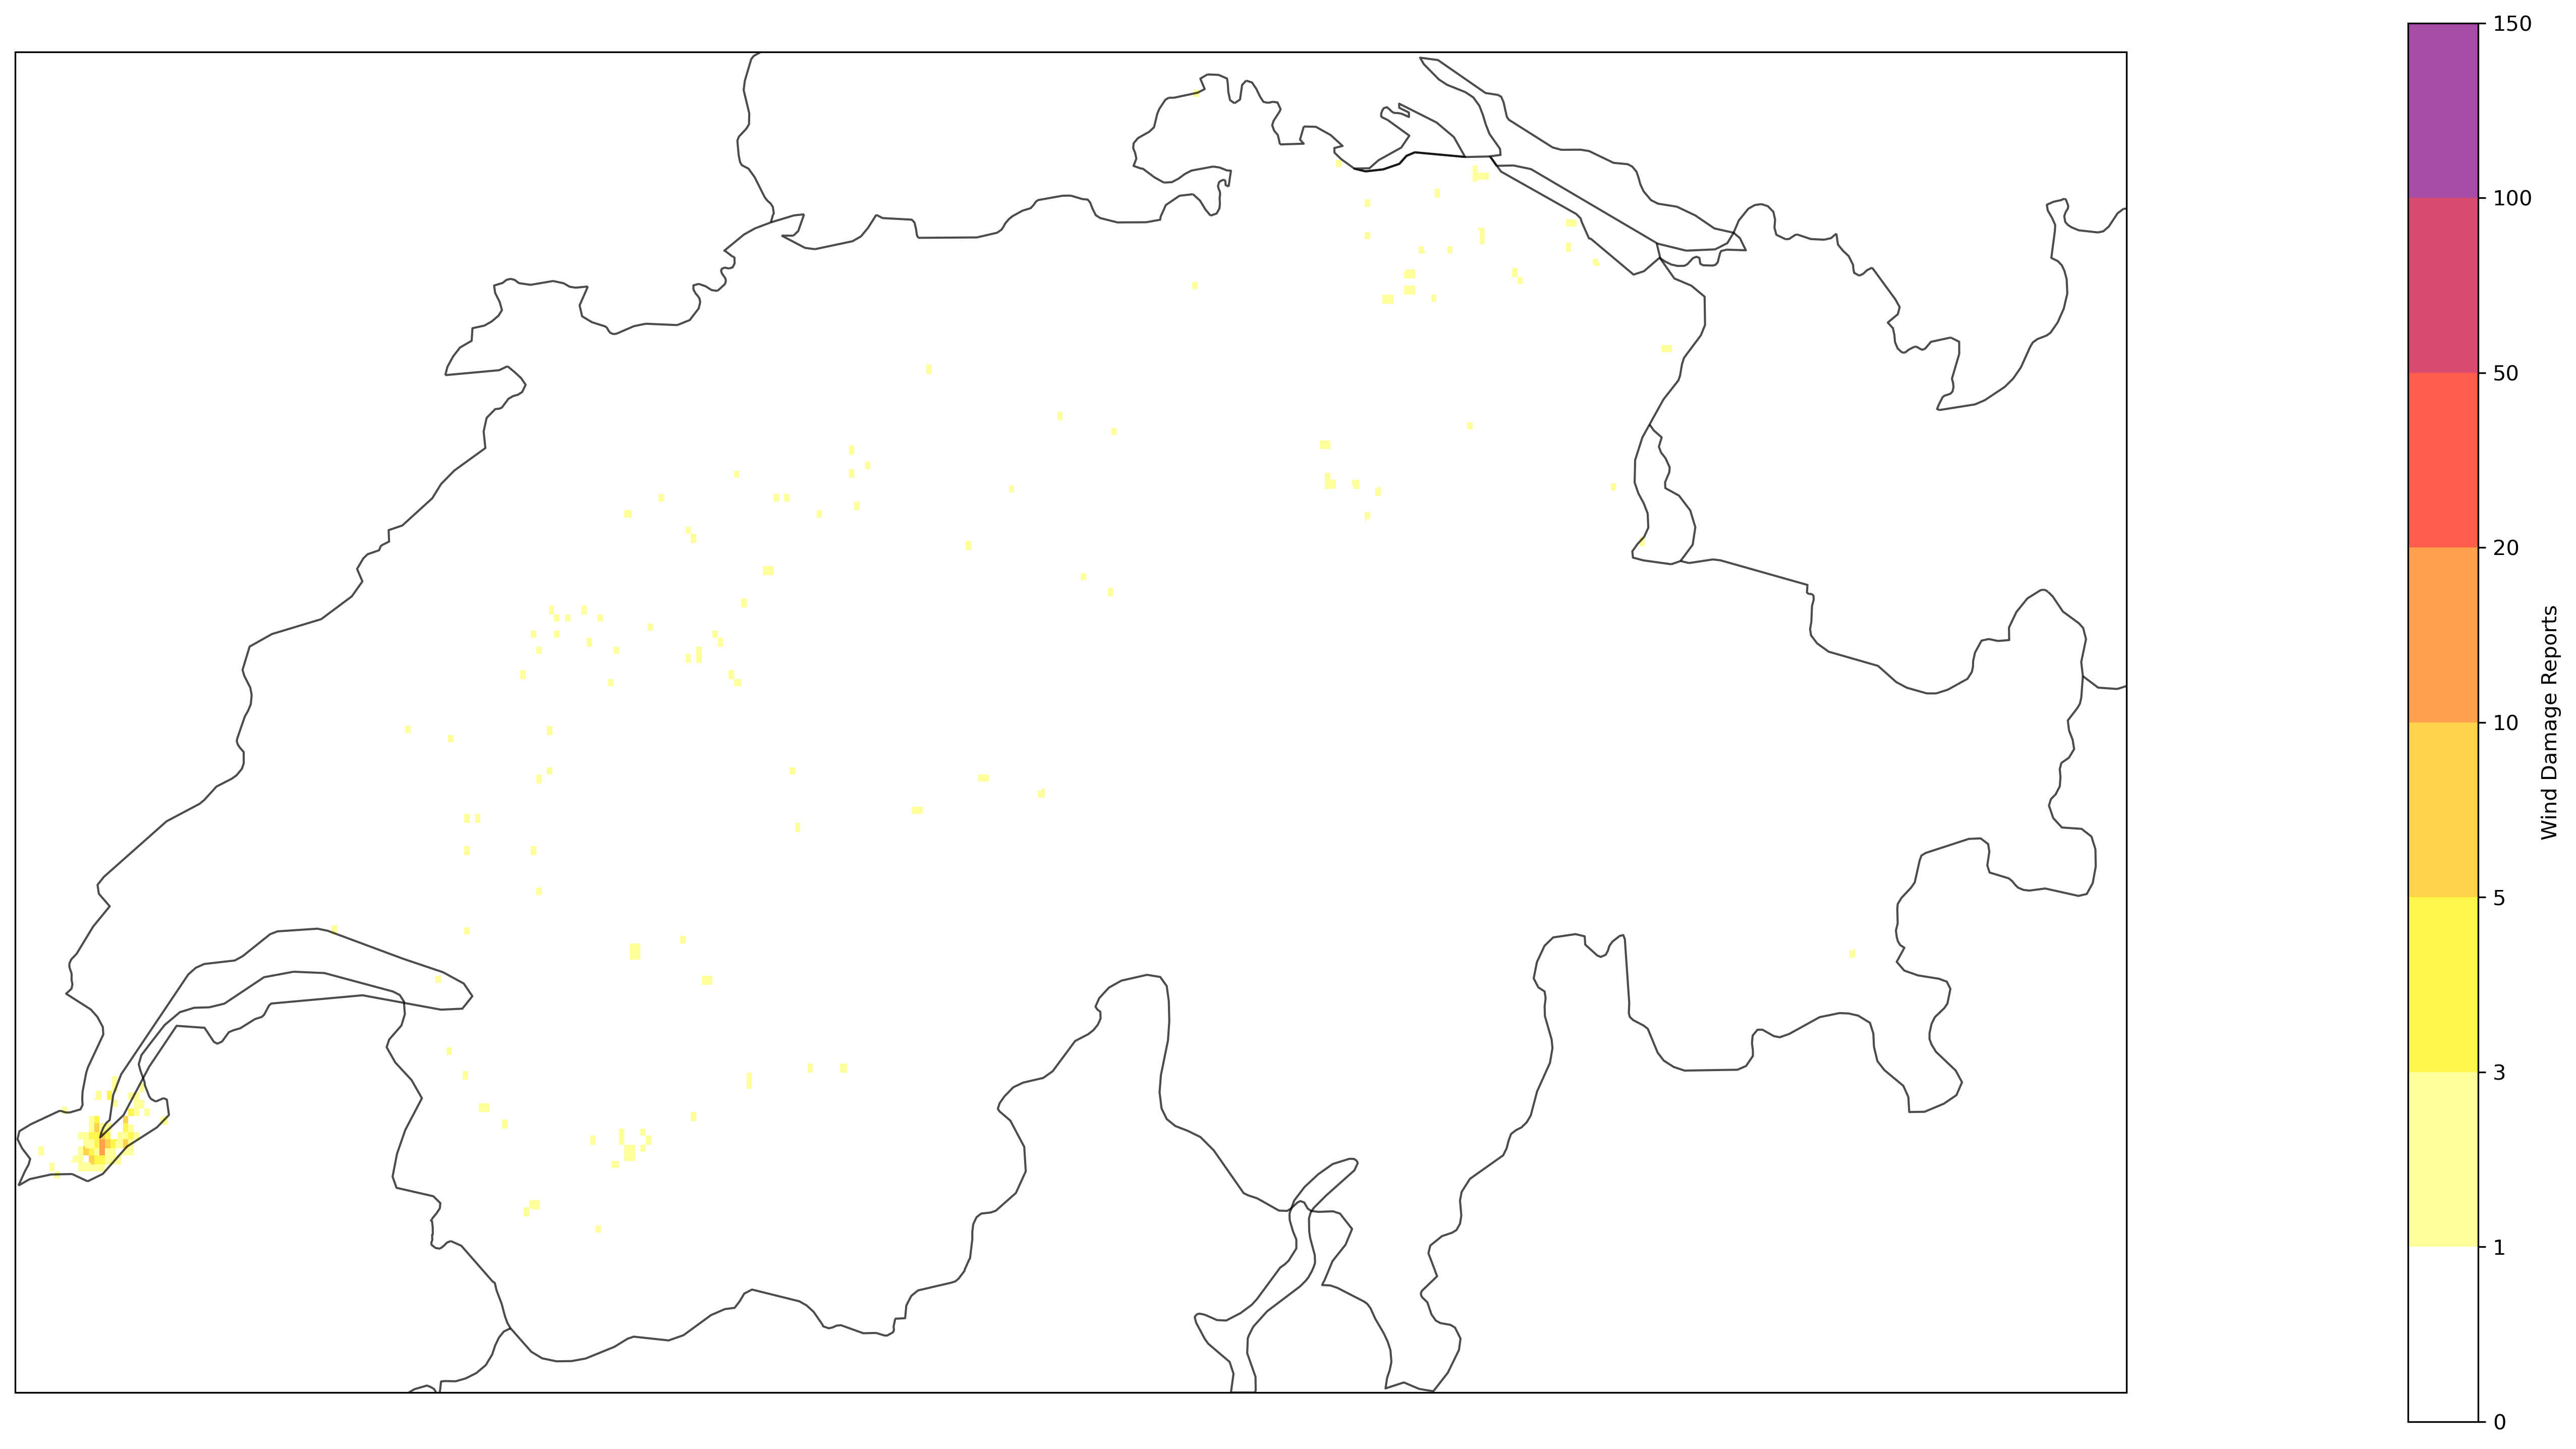

In [ ]:


# Set the projection to WGS84
projection = ccrs.epsg(2056)

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection}, dpi=300)

schaden_levels = np.array([0, 1, 3, 5, 10, 20, 50, 100, 150])
schaden_norm= BoundaryNorm(boundaries=schaden_levels, ncolors=256, clip=True)
cmap_schaden = LinearSegmentedColormap.from_list("custom_cmap", ["white","yellow", "orange", "red","purple"], N=256)

# Set background to white for the plot
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Define the path and open the GeoTIFF file
path = "/scratch/mch/fackerma/orders/Schadendaten/"
target_date = "20190615"
file_name = f"Schaeden_{target_date}_Sturmwind.tif"
file_path = os.path.join(path, file_name)

with rasterio.open(file_path) as src:
    # Define target CRS
    dst_crs = 'EPSG:4326'

    # Calculate the optimal resolution and transformation parameters
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Create a new array to store the reprojected data
    reprojected_data = np.zeros((height, width), dtype=src.dtypes[0])

    # Reproject the data
    reproject(
        source=rasterio.band(src, 1),
        destination=reprojected_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Mask nodata values
    reprojected_data = np.ma.masked_equal(reprojected_data, src.nodata)

    # Calculate new bounds
    west, south, east, north = rasterio.transform.array_bounds(height, width, transform)

    # Plot the reprojected raster data
    img = ax.imshow(reprojected_data, extent=(west, east, south, north), 
                    transform=ccrs.PlateCarree(), cmap=cmap_schaden, norm=schaden_norm ,alpha=0.7)

# Add colorbar for the raster data
cbar = plt.colorbar(img, ax=ax, label="Wind Damage Reports", pad=0.1, cmap=cmap_schaden, norm=schaden_norm, boundaries=schaden_levels, ticks=schaden_levels)


# Set the extent of the map to Switzerland (you may need to adjust these values)
ax.set_extent([5.9, 10.5, 45.8, 47.8], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.7)




#plt.savefig("/users/fackerma/newproject1/figures/first_case/stationen_schaden.png", dpi=300, bbox_inches='tight')


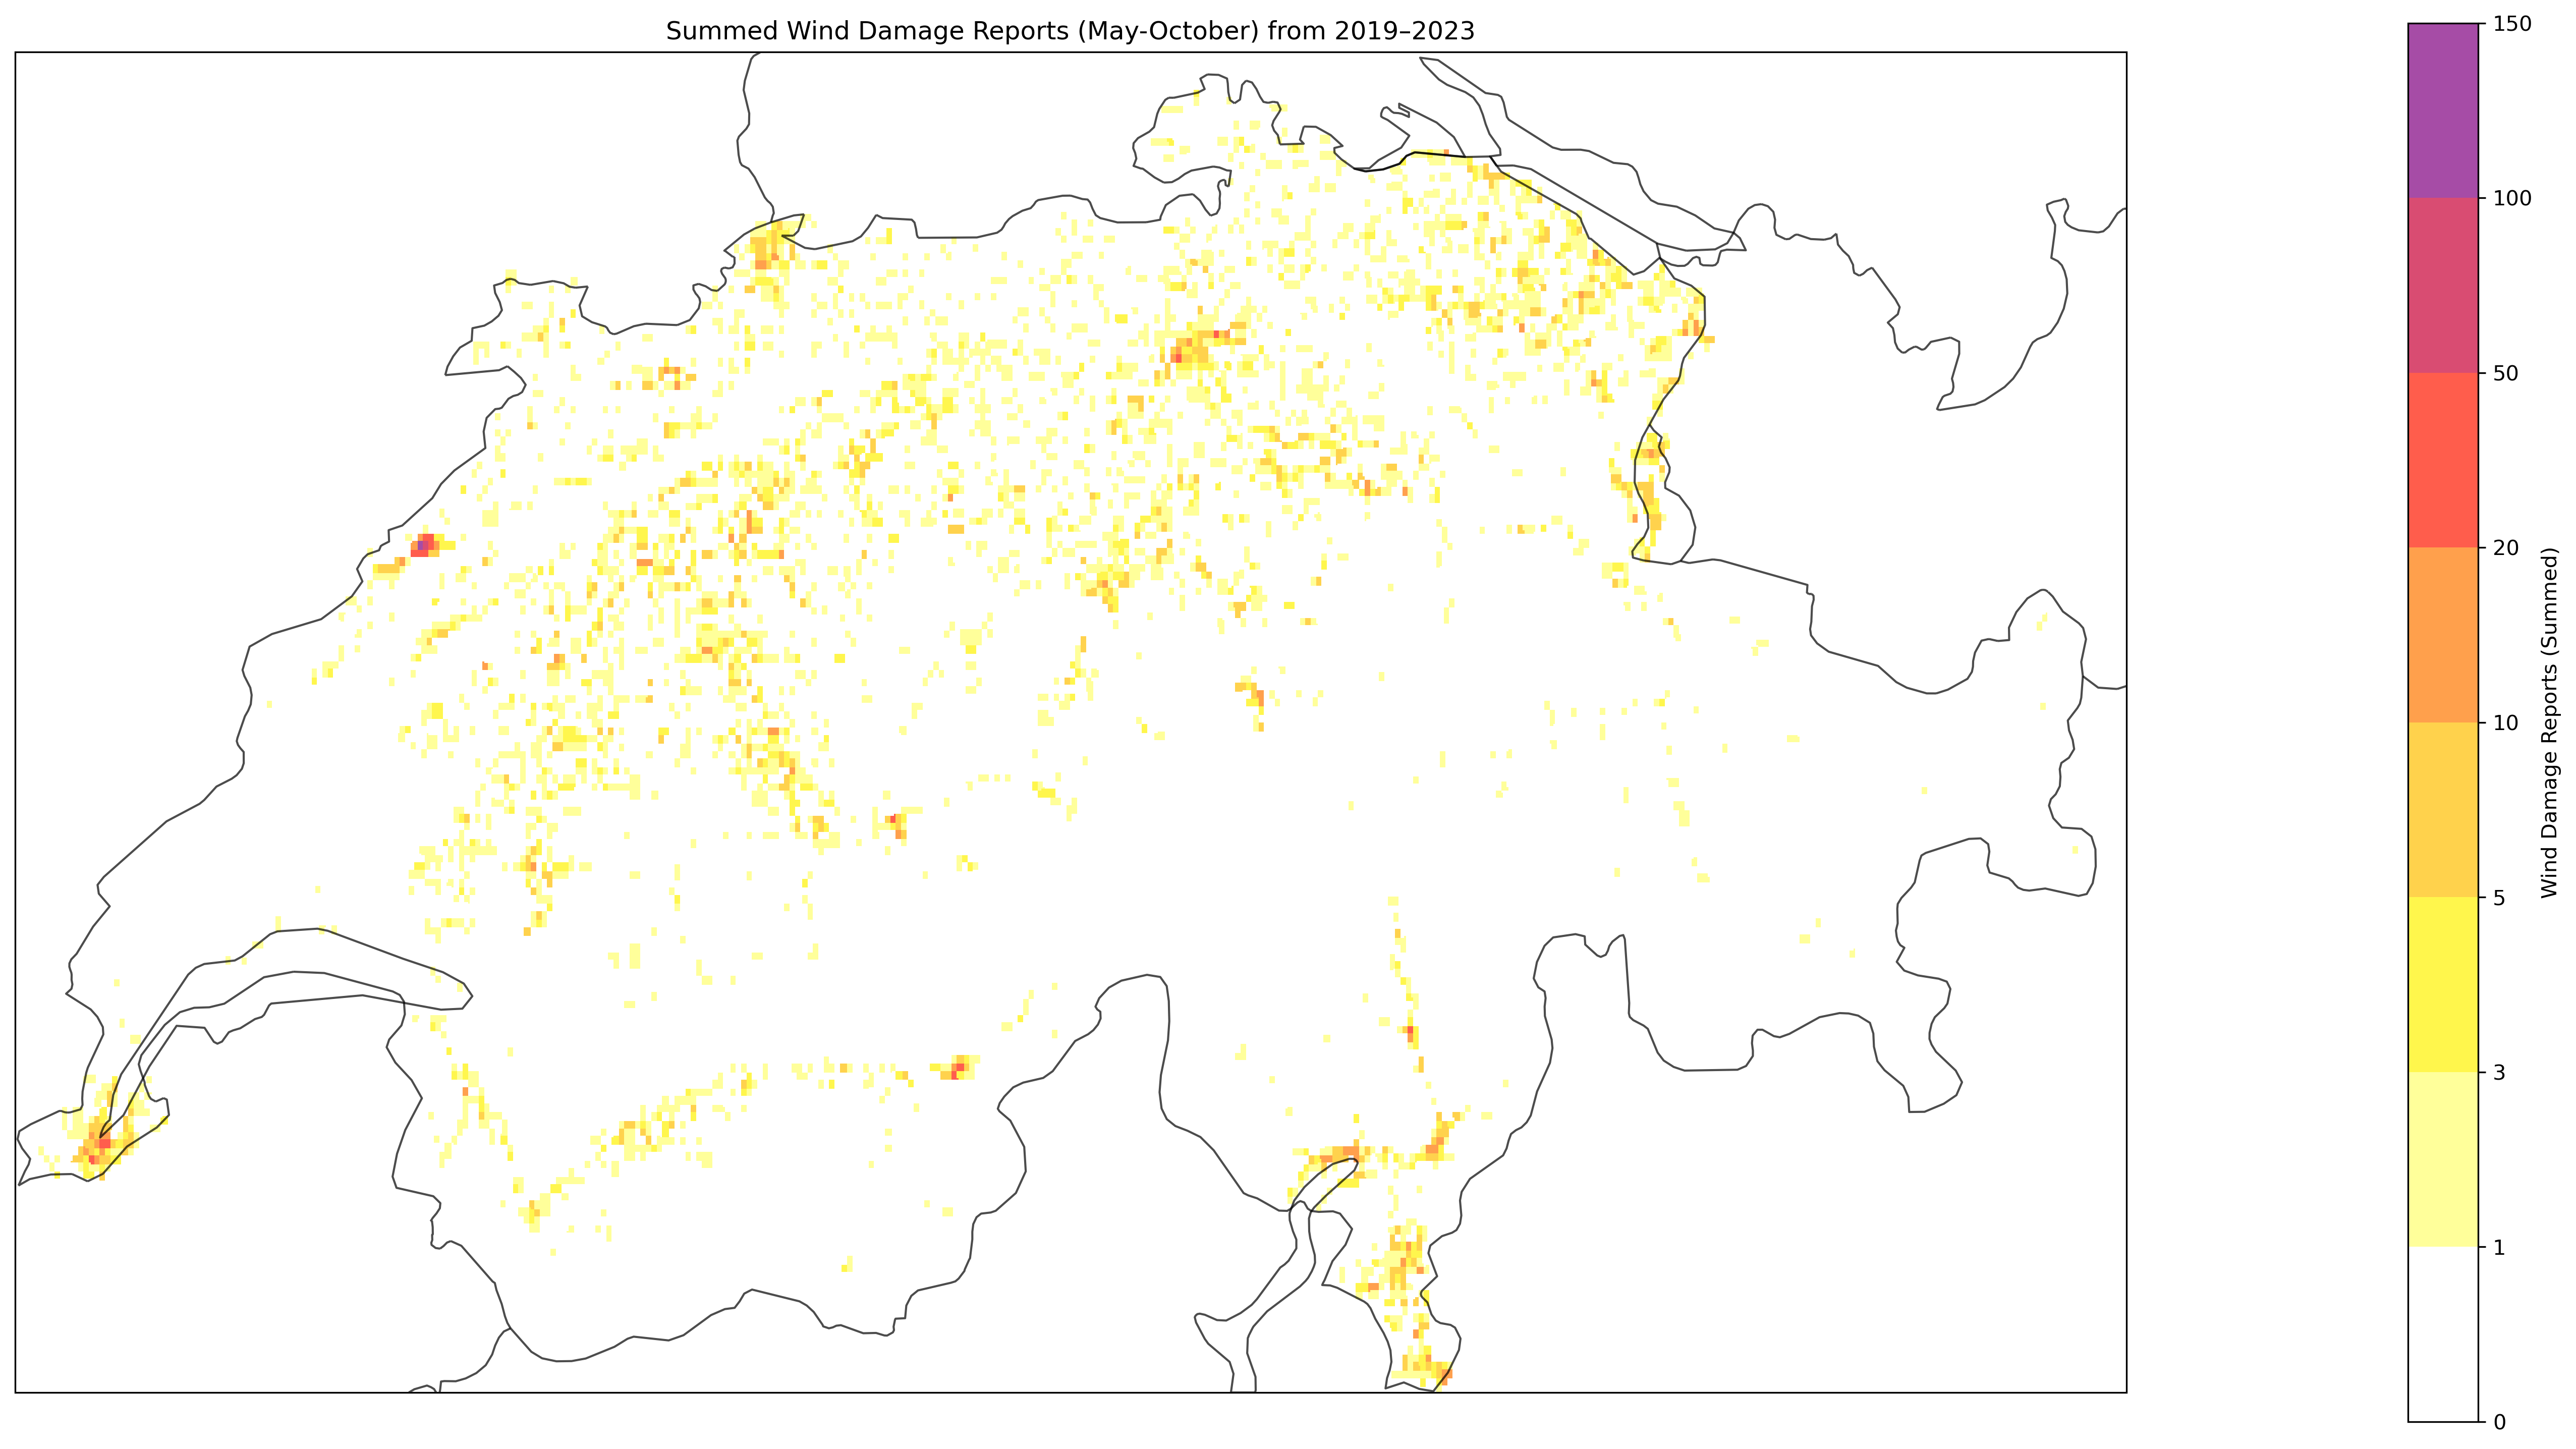

<Figure size 640x480 with 0 Axes>

In [2]:
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define parameters
path = "/scratch/mch/fackerma/orders/Schadendaten/"
start_year = 2019
end_year = 2023
start_month = 5  # May
end_month = 10  # October

# Define projection and visualization settings
projection = ccrs.epsg(2056)
schaden_levels = np.array([0, 1, 3, 5, 10, 20, 50, 100, 150])
schaden_norm = BoundaryNorm(boundaries=schaden_levels, ncolors=256, clip=True)
cmap_schaden = LinearSegmentedColormap.from_list("custom_cmap", ["white", "yellow", "orange", "red", "purple"], N=256)

# Initialize variables for summing data
combined_data = None
transform = None

# Loop through years and months to process files
for year in range(start_year, end_year + 1):
    for month in range(start_month, end_month + 1):
        for day in range(1, 32):  # Days in month (will check validity later)
            try:
                # Construct file name and path
                file_name = f"Schaeden_{year}{month:02d}{day:02d}_Sturmwind.tif"
                file_path = os.path.join(path, file_name)

                # Check if file exists
                if not os.path.exists(file_path):
                    continue

                # Open and process the file
                with rasterio.open(file_path) as src:
                    # Define target CRS (WGS84)
                    dst_crs = 'EPSG:4326'

                    # Calculate transformation parameters for reprojection
                    transform_temp, width_temp, height_temp = calculate_default_transform(
                        src.crs, dst_crs, src.width, src.height, *src.bounds)

                    # Initialize combined_data if it's the first file processed
                    if combined_data is None:
                        transform = transform_temp
                        combined_data = np.zeros((height_temp, width_temp), dtype=np.float32)

                    # Reproject data to target CRS and resolution
                    reprojected_data = np.zeros((height_temp, width_temp), dtype=np.float32)
                    reproject(
                        source=rasterio.band(src, 1),
                        destination=reprojected_data,
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )

                    # Mask nodata values and add to combined_data
                    reprojected_data = np.ma.masked_equal(reprojected_data, src.nodata)
                    combined_data += np.nan_to_num(reprojected_data)  # Replace masked values with zeros before summing

            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
                continue

# Calculate bounds for plotting based on transform
height_combined, width_combined = combined_data.shape
west, south, east, north = array_bounds(height_combined, width_combined, transform)

# Plotting the combined data
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection}, dpi=300)

# Set background to white for the plot
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the combined raster data
img = ax.imshow(combined_data, extent=(west, east, south, north),
                transform=ccrs.PlateCarree(), cmap=cmap_schaden,
                norm=schaden_norm, alpha=0.7)

# Add colorbar for the raster data
cbar = plt.colorbar(img, ax=ax, label="Wind Damage Reports (Summed)", pad=0.1,
                    cmap=cmap_schaden, norm=schaden_norm,
                    boundaries=schaden_levels,
                    ticks=schaden_levels)

# Set the extent of the map to Switzerland (adjust if necessary)
ax.set_extent([5.9, 10.5, 45.8, 47.8], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linestyle='-', alpha=0.7)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', alpha=0.7)
ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='black', facecolor='none', alpha=0.7)

plt.title("Summed Wind Damage Reports (May-October) from 2019–2023")
plt.show()

#plt.savefig('/users/fackerma/newproject1/figures/Ground_Truth/Mobiliar_2019-2023.png')
